# Model Testing
- Author: Daniel Zurawski, Keshav Kapoor
- Organization: Fermilab
- Grammar: Python 3.6.1

In [ ]:
!nvidia-smi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker3d import loader, utils, metrics

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


## Loading in Data

In [4]:
%%time
order        = ("phi", "r", "z")
code         = (order[0][0] + order[1][0] + order[2][0]).upper()
n_noise      = 0
num_classes  = 25 + 2
input_shape  = (233, 3)
opt          = "rmsprop"
modelpath    = "models/KESHAV-DATA-PRZ-0N.h5".format(code, n_noise)
train_data, train_target = loader.from_file("datasets/npz/unif25_prz_n10.npz")
test_data,  test_target  = loader.from_file("datasets/npz/ramp_prz_n10.npz")

print("train_data: {0}, train_target: {1}".format(train_data.shape, train_target.shape))
print("test_data: {0}, test_target: {1}".format(test_data.shape, test_target.shape))

train_data: (3993, 233, 3), train_target: (3993, 233, 27)
test_data: (3600, 233, 3), test_target: (3600, 233, 27)
CPU times: user 1.37 s, sys: 68 ms, total: 1.44 s
Wall time: 1.44 s


## Display an Example of the Data

In [27]:
e = np.random.randint(len(test_data))
print("Event {}".format(e))
utils.display_side_by_side(test_data[e], test_target[e], order=order)

Event 414


,phi,r,z
0,-3.124926,39.0,6.705182
1,-1.983928,39.0,-3.428368
2,-1.965867,85.0,-7.472084
3,-1.932729,155.0,-13.625565
4,-1.901751,213.0,-18.724163
5,-1.870934,271.0,-23.822762
6,-1.796660,405.0,-35.602283
7,-1.784943,213.0,82.276588
8,-1.706471,562.0,-49.403660
9,-1.586544,762.0,-66.985031


<IPython.core.display.Javascript object>


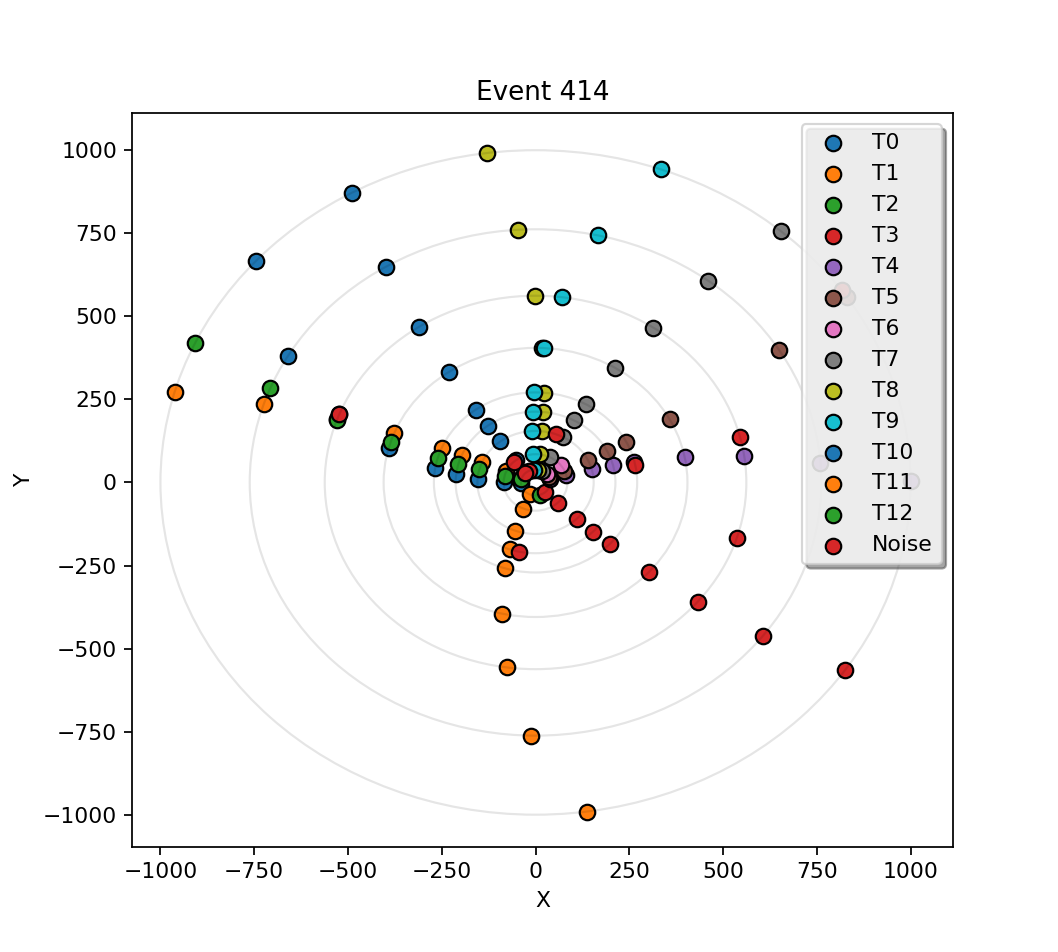

<IPython.core.display.Javascript object>


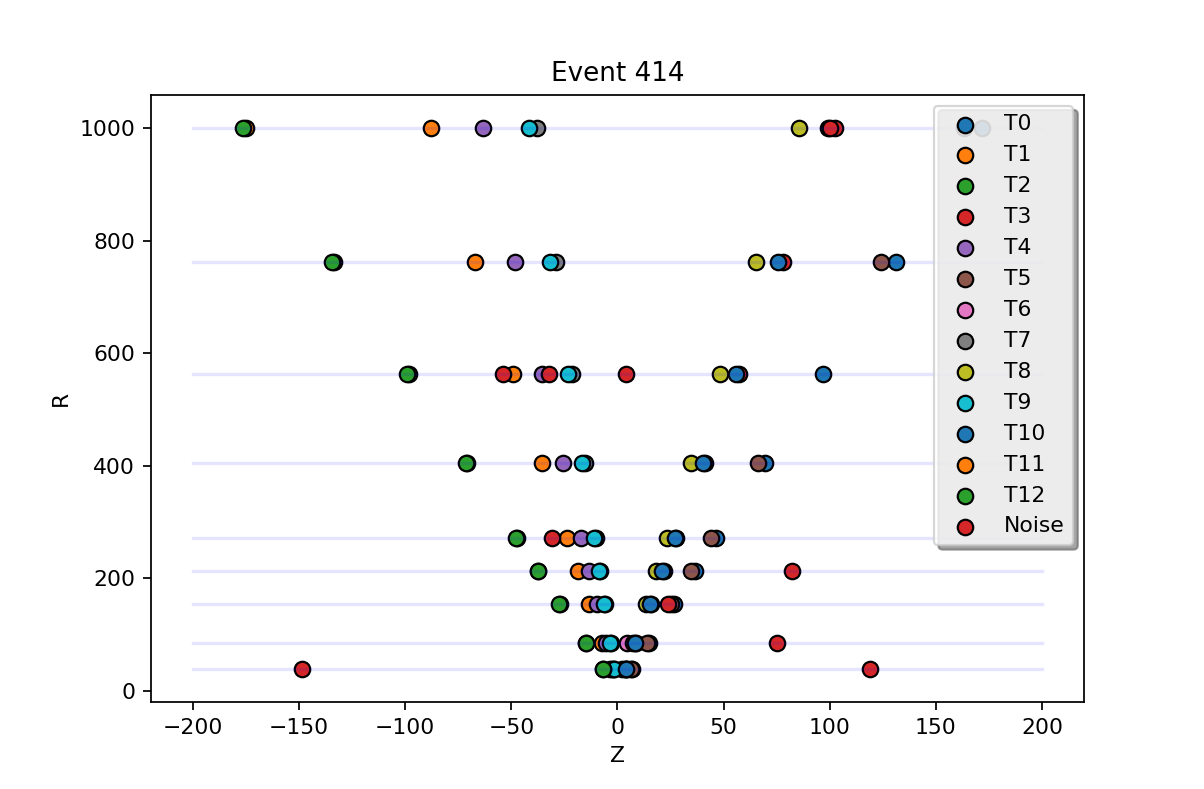

<IPython.core.display.Javascript object>


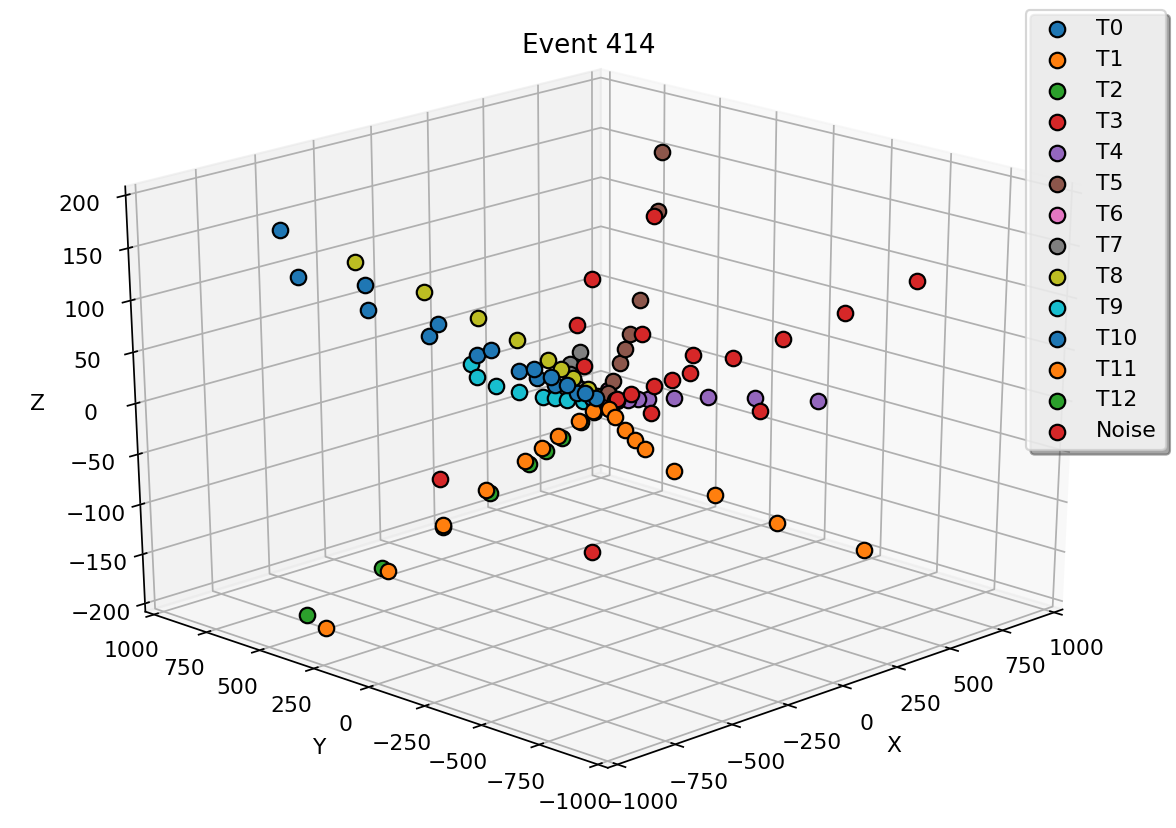

In [28]:
utils.plot3d(test_data[e], test_target[e], order=order, title="Event {}".format(e), flat_ax="z")
utils.plot3d(test_data[e], test_target[e], order=order, title="Event {}".format(e), flat_ax="r")
utils.plot3d(test_data[e], test_target[e], order=order, title="Event {}".format(e), flat_ax=None)

## Defining the Neural Network Model

In [9]:
# For reloading the model.
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(
        units=256,
        return_sequences=True,
        recurrent_dropout=0.4,
        implementation=2),
    input_shape=input_shape,
    merge_mode="mul"))
model.add(Dropout(0.4))
for _ in range(2):
    model.add(Bidirectional(
        GRU(
            units=256, 
            return_sequences=True, 
            recurrent_dropout=0.4, 
            implementation=2),
        merge_mode="mul"))
    model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(output_shape, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

## Fitting the Neural Network Model

In [ ]:
%%time
epochs     = 128
batch_size = 32
histories = model.fit(
    train_data,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(test_data, test_target),
    callbacks=[keras.callbacks.ModelCheckpoint(
        filepath=modelpath,
        save_best_only=True,
        verbose=0
    )]
)

## Plots of Predictions

In [10]:
guesses = model.predict(test_data)
print("Discrete Accuracy: {}".format(metrics.discrete_accuracy_all(test_data, guesses, test_target)))

Discrete Accuracy: 0.9132802475426846


In [29]:
discrete_acc = metrics.discrete_accuracy(guesses[e], test_target[e])
print("Event {0}: Discrete Accuracy {1}".format(e, discrete_acc))
utils.display_side_by_side(test_data[e], guesses[e], test_target[e], order=order)

Event 414: Discrete Accuracy 0.9279279279279279


,phi,r,z
0,-3.124926,39.0,6.705182
1,-1.983928,39.0,-3.428368
2,-1.965867,85.0,-7.472084
3,-1.932729,155.0,-13.625565
4,-1.901751,213.0,-18.724163
5,-1.870934,271.0,-23.822762
6,-1.796660,405.0,-35.602283
7,-1.784943,213.0,82.276588
8,-1.706471,562.0,-49.403660
9,-1.586544,762.0,-66.985031


<IPython.core.display.Javascript object>


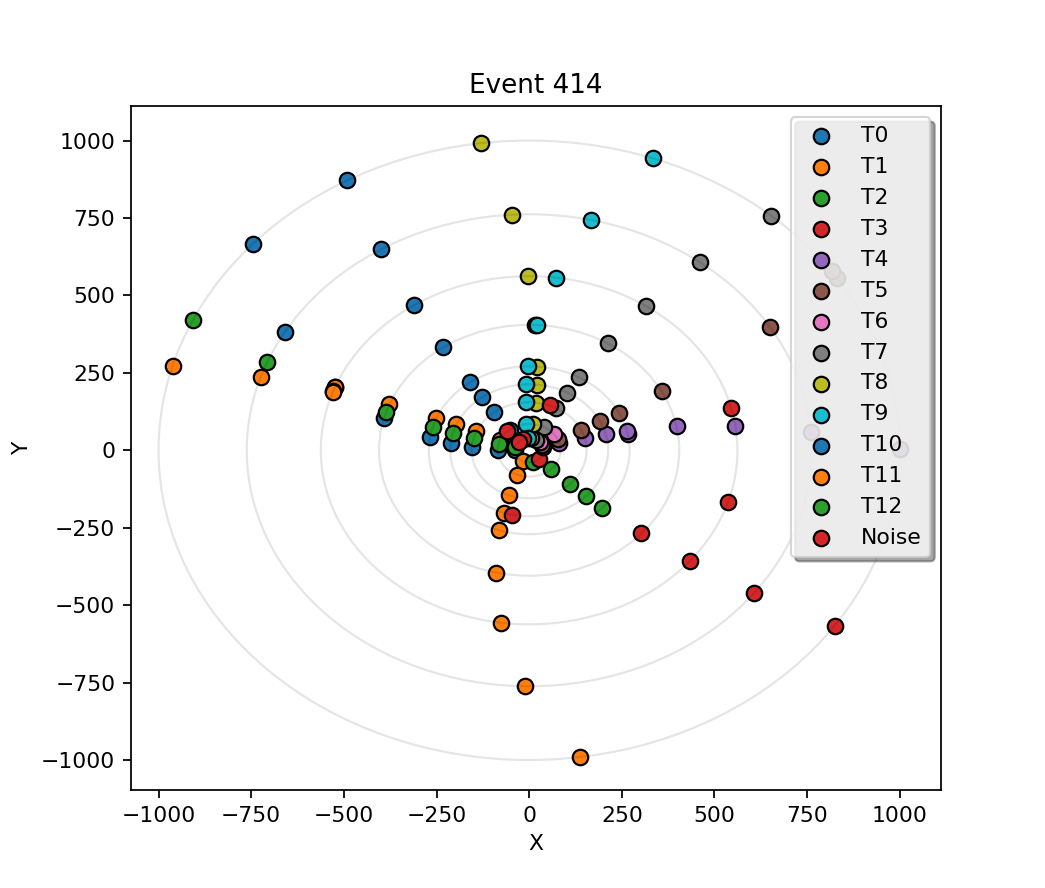

<IPython.core.display.Javascript object>


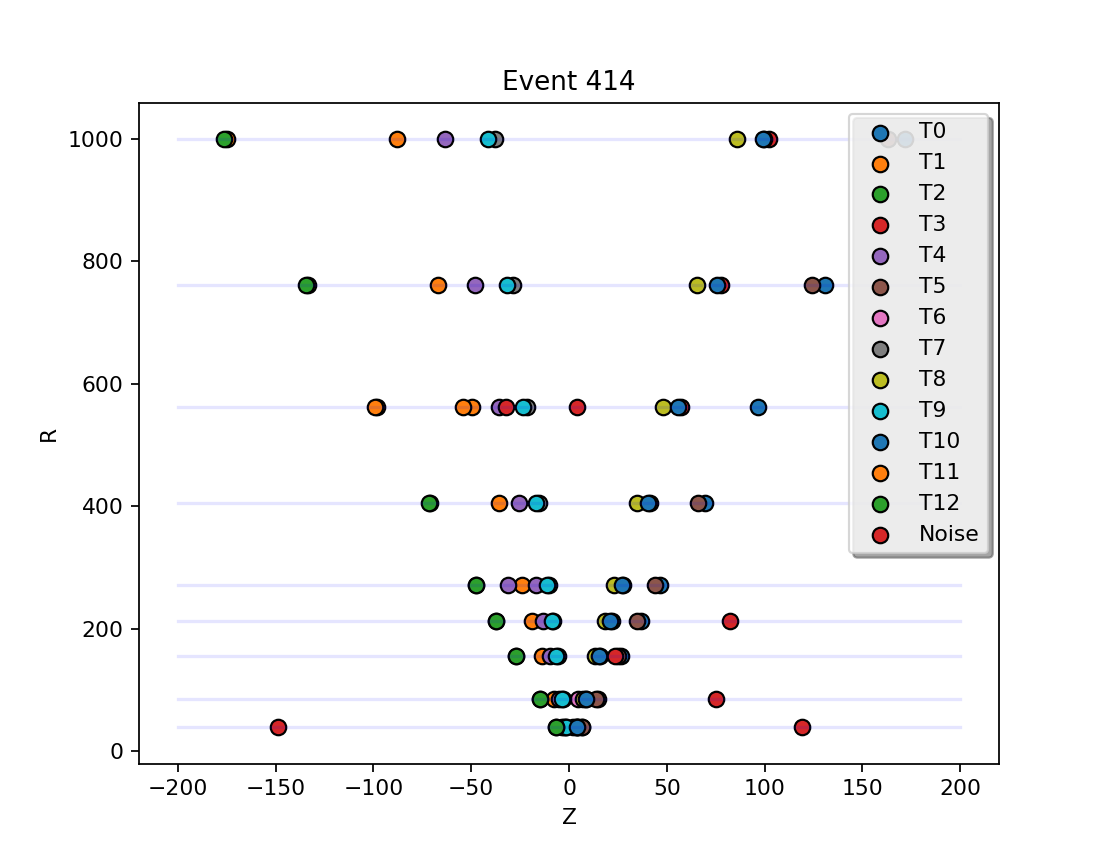

<IPython.core.display.Javascript object>


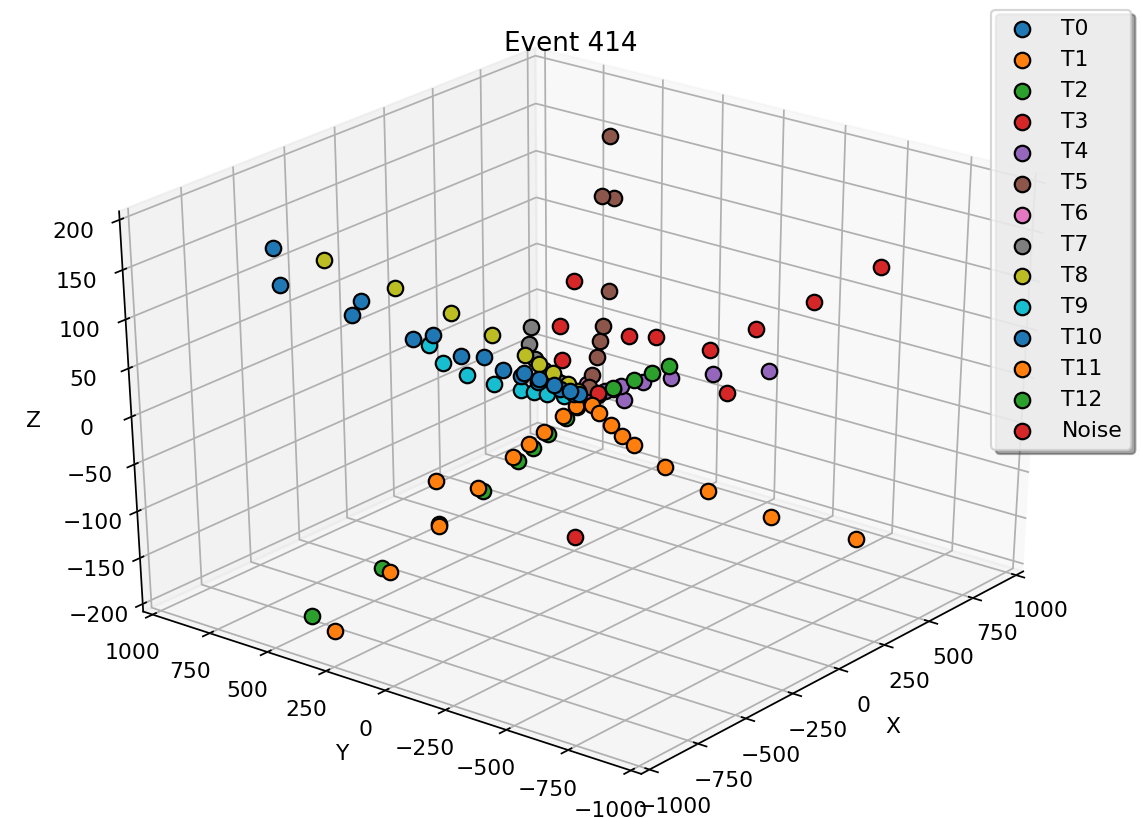

In [30]:
utils.plot3d(test_data[e], guesses[e], test_target[e], order=order, title="Event {}".format(e), flat_ax="z")
utils.plot3d(test_data[e], guesses[e], test_target[e], order=order, title="Event {}".format(e), flat_ax="r")
utils.plot3d(test_data[e], guesses[e], test_target[e], order=order, title="Event {}".format(e), flat_ax=None)

<IPython.core.display.Javascript object>


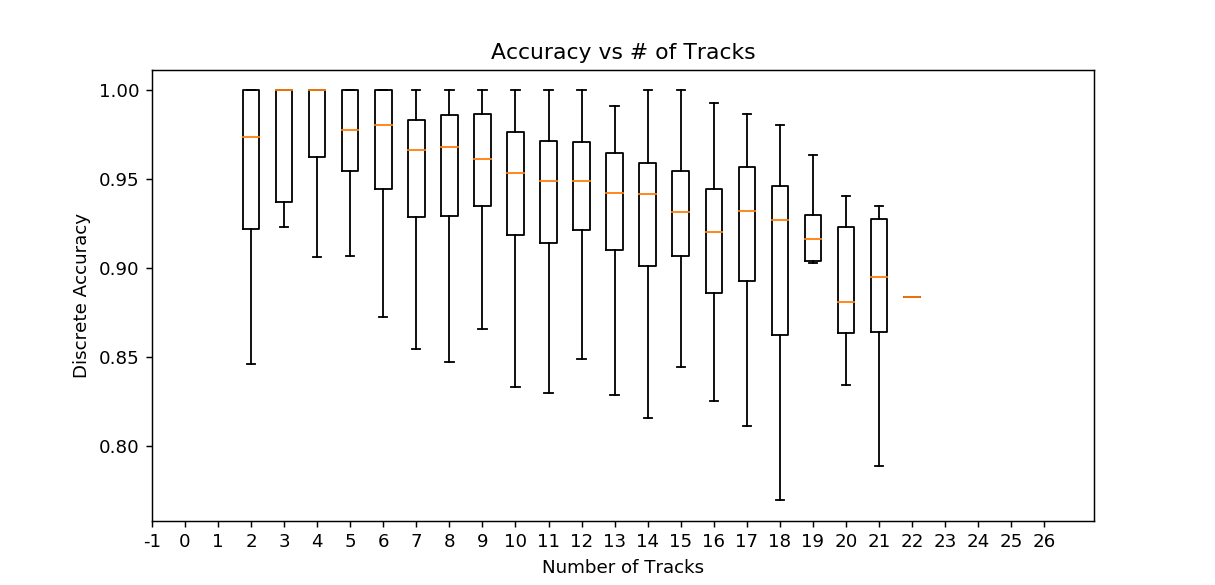

<IPython.core.display.Javascript object>


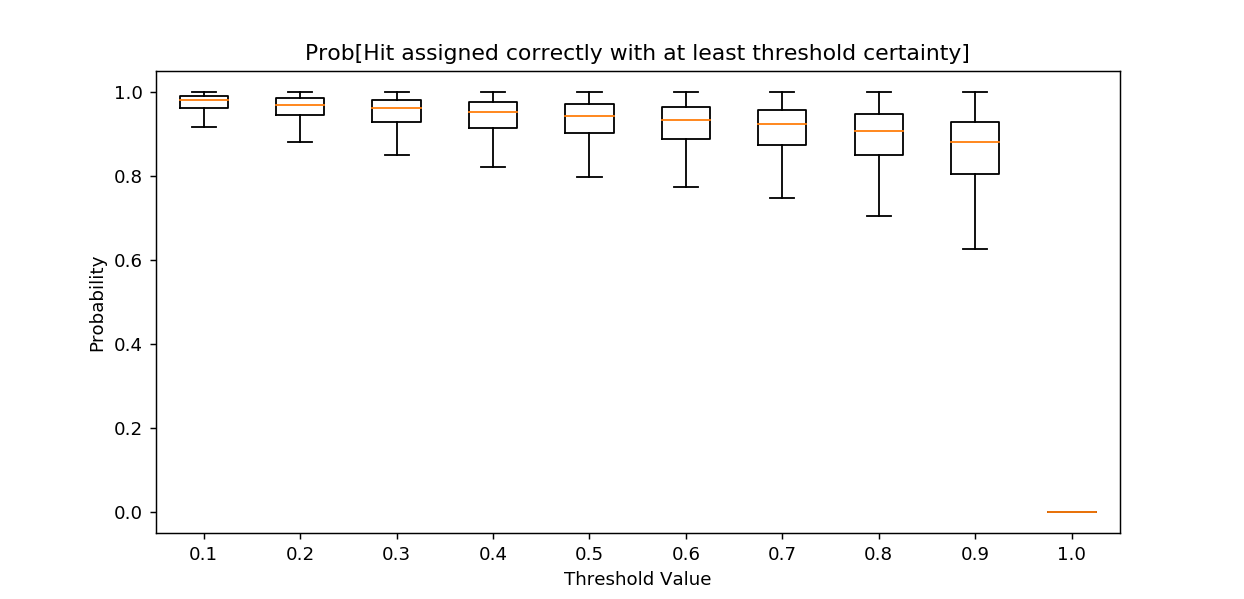

<IPython.core.display.Javascript object>


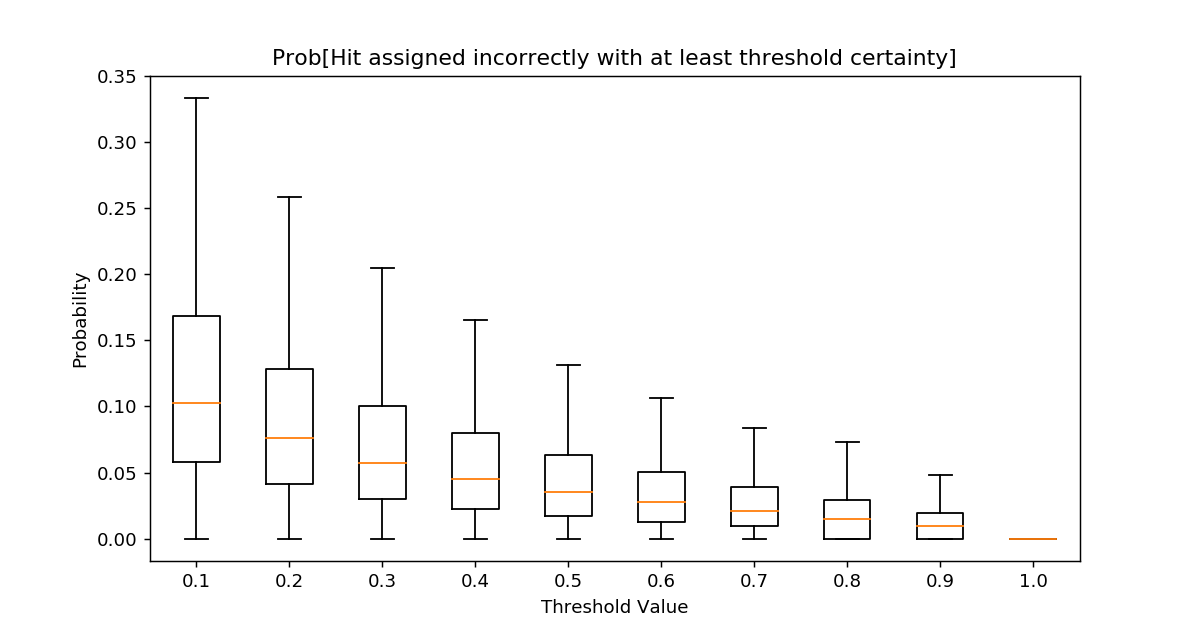

<IPython.core.display.Javascript object>


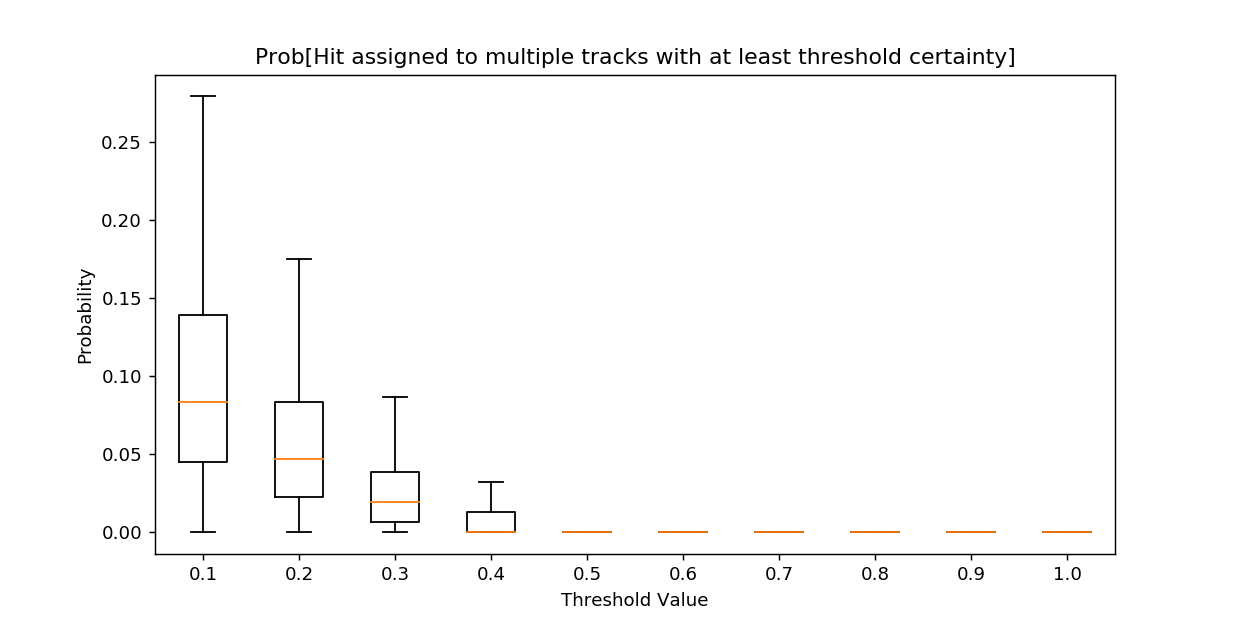

<IPython.core.display.Javascript object>


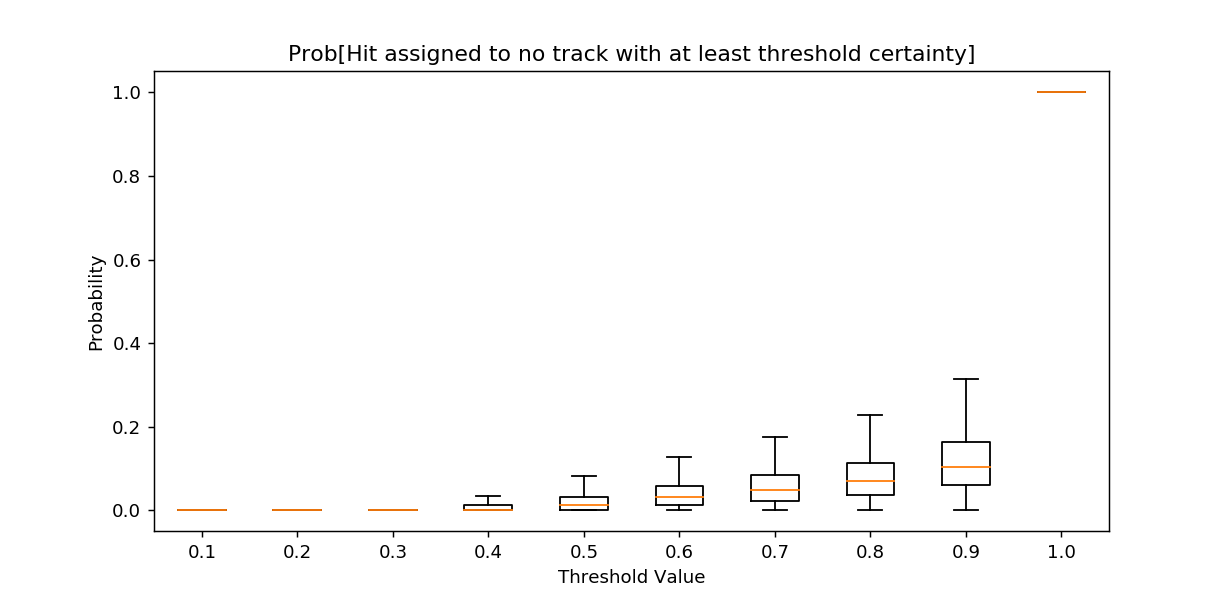

In [33]:
thresholds = [i / 10 for i in range(1, 1 + 10)]
_ = metrics.accuracy_vs_tracks_boxplot(guesses, test_target, noise=False)
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="correct")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="incorrect")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="many")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="none")